![title](sample_image.png)
# 0 - Algoritmo empleado:
1. **Instalación** y requisitos
2. **Entrenamiento.** En este  paso se crean las clases necesarias para la configuración de las nuevas categorias a entrenar. Se crea un objeto modelo en modo inferencia. Se entrena mediante GPU 30 epocas con todos los elementos del dataset. El modelo se va guardando al final de cada epoca en formato h5.
3. **Inferencia.** Una vez entrenado el modelo en la anterior fase, se crea un nuevo modelo en modo de inferencia. En este modo se carga los pesos guradados y se comprueba sobre imagenes de validación para ver comprobar el resultado. Igualmente se carga imagenes fuera de los conjuntos de validación y de test para comprobar de manera visual que funciona en la detección. 

In [15]:
#!pip install imutils
#!pip install scikit-image
#!pip install opencv-python
#!pip install imgaug
#!pip install Cython
#!pip install pycocotools
#!pip install kaggle
#!pip install keras

# 1 - Instalación y requisitos
## Importación de paquetes necesarios
Mask R-CNN se carga desde el **directorio local**, es una versión adaptada a la **rama 2.0 de Tensorflow**. El proyecto original de Mask RCNN no se ha actualizado. La dirección __[Mask RCNN Tensorflow 2](https://github.com/alsombra/Mask_RCNN-TF2)__

De Mask RCNN se importan las clases de modelo y de visualización que luego se utilizarán en para la parte de inferencia


In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
import json
import tensorflow as tf
from matplotlib import pyplot
from matplotlib.patches import Rectangle
#from mrcnn import door
import skimage.draw
%matplotlib inline

## Comprobamos la versión de Tensorflow que estamos usando

In [2]:
f'La version de Tensorflow que estamos usando en el entorno es la {tf.__version__}'

'La version de Tensorflow que estamos usando en el entorno es la 2.4.1'

## Comprobar que las GPU están operativas dentro de Tensorflow

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
#el metodo set_memory_growth permite utilizar la memoria de la GPU conforme la necesitemos y no reservandola toda al inicio
tf.config.experimental.set_memory_growth(physical_devices[0], True)
f'Nombre y tipo de dispositivo {physical_devices[0]}'

"Nombre y tipo de dispositivo PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')"

# 2 - Fase de Entrenamiento
## Configurar la clase para la configuracion.
Se parte de la clase "Config" y se personaliza a nuestro caso a la clase "DoorConfig" Esta configuración es distinta a la de inferencia. Interesa ajustar el numero de imagenes por gpu al maximo de la memoria de nuestra tarjeta, a mayor numero de batch converge más rapido. Si solo se pone una imagen por batch puede no converger. 

In [4]:
#Se crea una clase hija desde la clase "Config" de mcrnn
#Vamos a crear la clase DoorConfig

class DoorConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # nombre para la configuración 
    NAME = "doors"

    # Numero de gpu utilizadas (se podría utilizar tensorflow en red).
    # Ajustar el numero de imagen con la memoria de la gpu que se este utilizando
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + doors

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100 #numero de imagenes dividido por las imagenes que entran en la gpu

    #
    VALIDATION_STEPS=50

    # Skip detections with < 90% confidence - nos permite eliminar los que no cumplan un minimo de exactitud
    DETECTION_MIN_CONFIDENCE = 0.9

## Clase para el Dataset
Se configura una clase para el dataset que proporcionemos, en este ejemplo tenemos una sola clase para el dataset, que añade la clase "door". En el caso de que nuestro dataset tuviera más clases habría que especificarlo. Hay que ajustar el dataset al software de anotaciones que hayamos utilizado. 

In [5]:
class DoorDataset(mrcnn.utils.Dataset):
    '''Configuracion del dataset para la nueva clase de entrenamiento
    '''

    def load_door(self, dataset_dir, subset):
        """Load a subset of the Door dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("door", 1, "door")

        # comprobamos que el subset del paramentro este dentro de los posibles valores (train o val)
        assert subset in ["train", "val"]
        # creamos la variable con uniendo el directorio origen del dataset con el directorio del entrenamiento o validación
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.

        #cargamos el fichero json con las anotaciones del correspondiente directorio (cada directorio tiene que tener su correspondiente fichero json) 
        #el nombre del fichero se corresponde con el nombre que VIA 1.06 nos da a las anotaciones
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        #nos quedamos con las anotaciociones 
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        #comprobamos que no tengamos anotaciones vacias VIA permite guardar la imagen incluso si no tiene anotacion. Con con la comprenhesion comprobamos que cada elemento tiene clave 'regions'
        annotations = [a for a in annotations if a['regions']]

        # añadimos la imagenes
        for a in annotations:

            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            
            #para cada imagen "a" extraemos el tamaño de la imagen, para ello usamos el paquete skimage
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            #añadimos la imagan con su etiqueta, si la imagenes están etiquetadas con el atributo regionatr podríamos extraerlo desde a['region_atributes']['object']
            self.add_image(
                "door",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Si no esta la clase en el dataset, delega sobre la clase madre
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "door":
            return super(self.__class__, self).load_mask(image_id)

        # Convierte los poligonos en una mascara de bitmap
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        #para cada poligono dibuja un poligono (paquete skimage)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "door":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


## Creamos una configuración de "entrenamiento"
Creamos un objeto configuración y ejecutamos un display para ver la configuración. Por defecto estamos cogiendo uns resnet para CNN y se inicializan los pesos de las funciones de perdida. Vamos a tener varias funciones de perdida correspondiente a las **"proposal region"**, a las **"bounding box refinement"**, a la **clasificación**, al **mask bounding box** y a la **propia máscara**. 5 funciones de perdida. 

In [21]:
TrainingConfig = DoorConfig # utilizamos "training" para separarlo de la posterior fase
config = TrainingConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Configuramos el directorio de trabajo del dataset

In [6]:
ROOT_DIR = os.path.abspath("../")
dataset = os.path.join(ROOT_DIR, "Datasets\\Door")
#dataset 

### Dision del Dataset
Para el conjunto de **entrenamiento** se han etiquetado las imagenes de la 1-200
para el conjunto de **validación** se han etiquetado las imagenes de la 200-250 


## Configuramos el dataset de **entrenamiento**

In [7]:
dataset_train = DoorDataset() #se crea un objeto DoorDataset 
dataset_train.load_door(dataset, "train") #se carga el dataset de entrenamiento
dataset_train.prepare() #se hacen las transformaciones previas en el dataset de entrenamiento

## Configuramos el dataset de **validación**

In [8]:
#igual para el dataset de validación
dataset_val = DoorDataset()
dataset_val.load_door(dataset, "val")
dataset_val.prepare()

## Modelo de entrenamiento

Hay que poner el modelo en modo **"training"** para poder entrenarlo, con la configuración antes creada y un **directorio** donde se iran guardando las distintos modelos cada vez que se haga una epoca de entrenamiento. 

Se crea un **"callback"** para poder llamar despues a Tensorboard y evaluar como esta funcionando el modelo.

In [25]:
print('loading  weights for Mask R-CNN model…')
model = modellib.MaskRCNN(mode='training', config=config, model_dir='./modelos/')

loading  weights for Mask R-CNN model…


Se cargan los pesos de la red entrenada para COCO __[COCO Dataset](https://arxiv.org/abs/1405.0312)__ A partir de estos pesos vamos a realizar la transferencia de aprendizaje a nuestras clases. Las capas finales de la red se congelan (la clasificacion logistica, los bounding box )

In [26]:
model.load_weights('./modelos/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

## Se entrena el modelo 
Se define un **learning rate** (en este caso el valor por defecto)

Se definen 20 **epocas** para entrenamiento

Solo se entrenan las **capas superiores**

In [9]:
model.set_log_dir('./logs')

NameError: name 'model' is not defined

In [ ]:
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')

# Modo Inferencia

En la nueva clase de configuracion para la inferencia vamos a tener solo una imagen por "lote" dado que ya solo vamos a trabajar con la imagen sobre la cual queremos pronosticar su mascara. 

In [10]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "door"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	#Se crea una clase hija desde la clase "Config" de mcrnn
	DETECTION_MIN_CONFIDENCE = 0.95

Se crea un nuevo objeto de configuracion para las predicdiones.

In [11]:
config = PredictionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Ponemos el modelo en modo inferencia

In [12]:
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='./modelos/')

Instructions for updating:
Use fn_output_signature instead


Definimos las clases que queremos predecir. Tenemos que añadir siempre la clase "BG"(background) a la clases o clases de estudio.

In [147]:
class_names = ['BG','door']

Cargamos los pesos con el último entrenamiento

In [14]:
model.load_weights('./modelos/doors20210814T1252/mask_rcnn_doors_0020.h5', by_name=True)

Re-starting from epoch 20


In [15]:
def draw_image_with_boxes(filename, boxes_list):
     # load the image
    data = pyplot.imread(filename)
     # plot the image
    pyplot.imshow(data)
     # get the context for drawing boxes
    ax = pyplot.gca()
     # plot each box
    for box in boxes_list:
          # get coordinates
        y1, x1, y2, x2 = box
          # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
          # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=5)
          # draw the box
        ax.add_patch(rect)
     # show the plot
    pyplot.show()

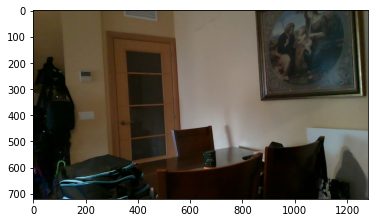

In [107]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
img = load_img('color.jpg')
pyplot.imshow(img)
img = img_to_array(img)

In [108]:
# make prediction
results = model.detect([img], verbose=0)

In [109]:
results[0]

{'rois': array([[ 73, 298, 541, 556]]),
 'class_ids': array([1]),
 'scores': array([0.97932535], dtype=float32),
 'masks': array([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        ...,
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],
 
        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]])}

In [119]:
results[0]['rois'][0][0]

96


*** No instances to display *** 



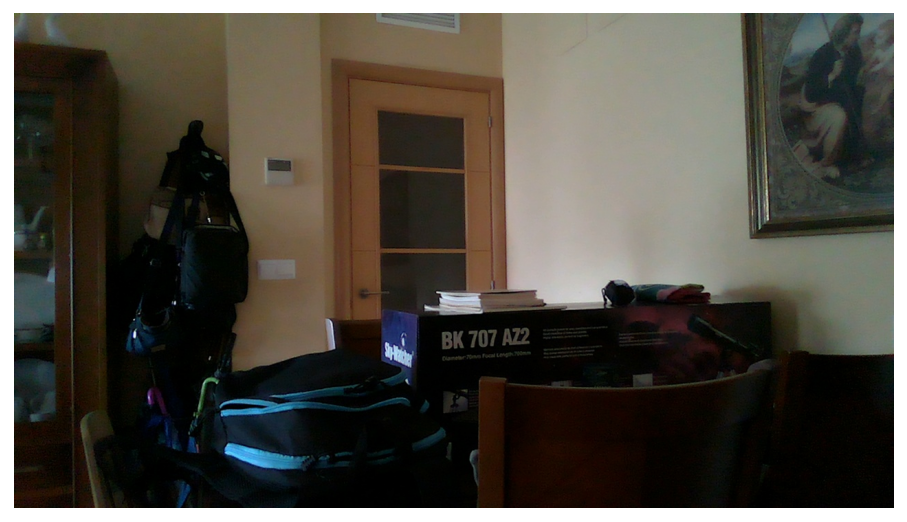

In [99]:
# get dictionary for first prediction
from mrcnn.visualize import display_instances
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [275]:
#First import the library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2

# Crea un pipelin para todo el proceso de captura
pipeline = rs.pipeline()

# Crea una configuración para el pipeline (se configurar color y el resto de caracteristicas de la captura)
config = rs.config()

#crea objeto pointcloud "vacio" en este objeto se 
pc = rs.pointcloud()


# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

#comprobacion para ver si el dispositivo tiene camara en color, 
found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)



config.enable_stream(rs.stream.depth, 1024, 768, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1920, 1080, rs.format.bgr8, 30)

In [233]:
pipeline.stop()

RuntimeError: stop() cannot be called before start()

Depth Scale is:  0.0002500000118743628


<Figure size 800x480 with 0 Axes>

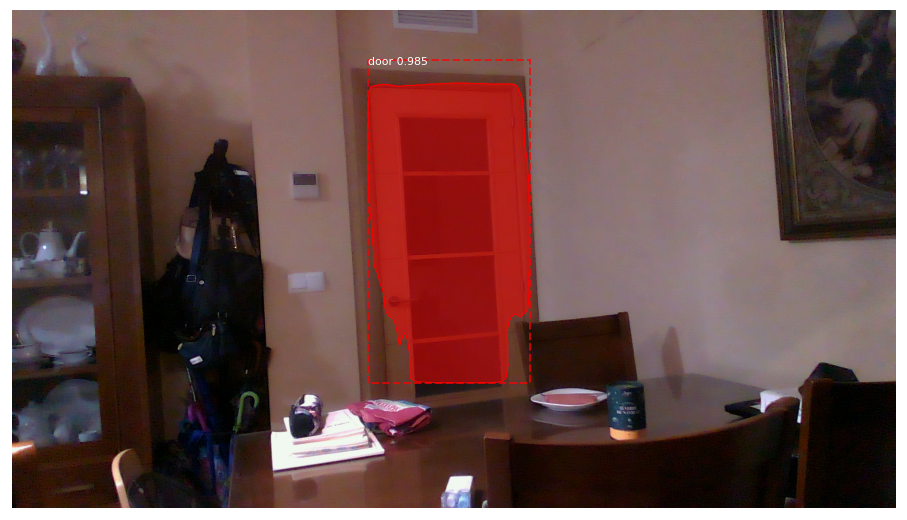

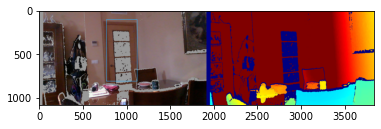

[[ 107  774  808 1125]]


In [323]:
#version matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)

# Start streaming
#pipeline.stop() #por si sigue activo el pipeline anterior
profile = pipeline.start(config)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# se recorta el fondo a partir de una distancia, los metros se pasan a unidades del mapa de profundidad
clipping_distance_in_meters = 9 #metros
clipping_distance = clipping_distance_in_meters / depth_scale

# Se crea un objeto de align se alinea la salida con 
align_to = rs.stream.color
align = rs.align(align_to)

frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)

filters = [rs.disparity_transform(),
               rs.spatial_filter(),
               rs.temporal_filter(),
               rs.disparity_transform(False)]

for f in filters:
    aligned_depth_frame = f.process(aligned_depth_frame)

aligned_depth_frame = aligned_frames.get_depth_frame() 



color_frame = aligned_frames.get_color_frame()
depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())
grey_color = 153
depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
images = np.hstack((bg_removed, depth_colormap))

class_names = ['BG','door']
results = model.detect([cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)], verbose=0)
r = results[0]
display_instances(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB), r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

for roi in results[0]['rois']:
    cv2.rectangle(images, (roi[1], roi[0]), (roi[3], roi[2]), (255, 178, 50), 3)

#mask_removed = np.where((r['masks'] == True ), grey_color, aligned_depth_frame)
points = pc.calculate(aligned_depth_frame)
points.export_to_ply('./out.ply', aligned_depth_frame)
vertices = np.asanyarray(points.get_vertices()).view(np.float32).reshape(1080, 1920, 3)

#plt.imshow(images) #sale con los colores invertidos por ser una imagen cv2 en numpy
#plt.axis('off')
plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('C:/Users/Jose/Desktop/color.jpg', color_image)
pipeline.stop()
print (results[0]['rois'])

In [324]:
vertices_rs = np.reshape(vertices, (-1, 3))
vertices_rs.shape

(2073600, 3)

In [325]:
roi=results[0]['rois'][0]
roi_vertices = vertices[roi[0]:roi[2], roi[1]:roi[3],:]
roi_vertices.shape


(701, 351, 3)

In [335]:
import open3d as o3d
roi_rs = np.reshape(roi_vertices, (-1, 3))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(roi_rs)
o3d.io.write_point_cloud("reshaped_roi.ply", pcd) 
masked = np.where((r['masks']==False), 0, vertices)

In [336]:
masked_rs = np.reshape(masked, (-1, 3))
pcd.points = o3d.utility.Vector3dVector(masked_rs)
o3d.io.write_point_cloud("masked.ply", pcd)

True

In [218]:
points = pc.calculate(aligned_depth_frame)
aligned_depth_frame
verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, 1024, 3)  # xyz

pcd.points = open3d.utility.Vector3dVector(verts)


RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [73]:
# Start streaming
profile = pipeline.start(config)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

Depth Scale is:  0.0002500000118743628


In [83]:
# se recorta el fondo a partir de una distancia, los metros se pasan a unidades del mapa de profundidad
clipping_distance_in_meters = 9 #metros
clipping_distance = clipping_distance_in_meters / depth_scale

# Se crea un objeto de align se alinea la salida con 
align_to = rs.stream.color
align = rs.align(align_to)

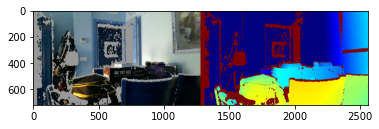

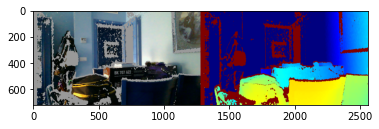

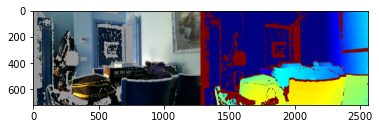

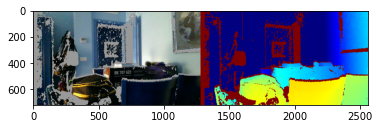

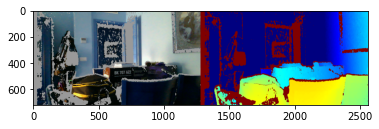

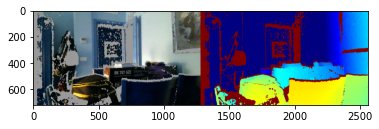

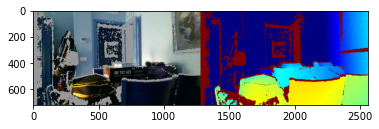

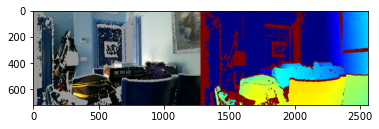

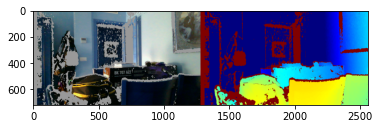

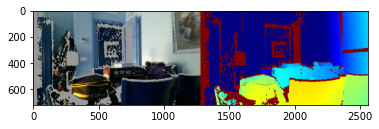

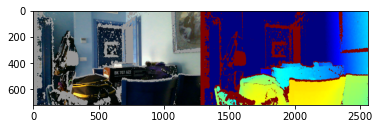

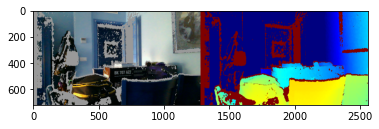

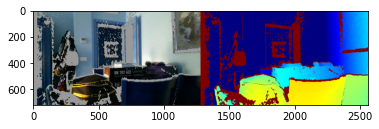

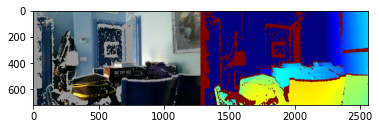

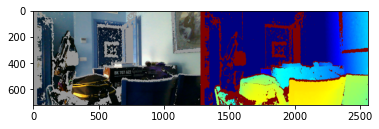

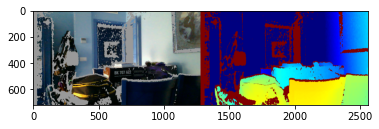

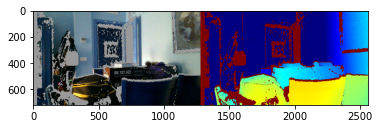

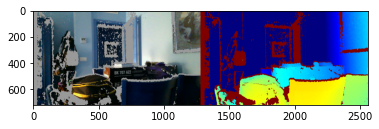

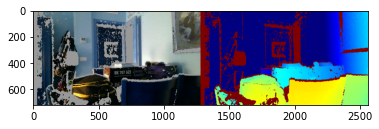

In [ ]:

# Streaming loop
try:
    while True:
        # Get frameset of color and depth
        frames = pipeline.wait_for_frames()
        # frames.get_depth_frame() is a 640x360 depth image

        # Align the depth frame to color frame
        aligned_frames = align.process(frames)

        # Get aligned frames
        aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frames.get_color_frame()

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        #r = model.detect([color_frame],verbose=0)
    



        # Remove background - Set pixels further than clipping_distance to grey
        grey_color = 153
        depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
        bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)

        # Render images:
        #   depth align to color on left
        #   depth on right
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        images = np.hstack((bg_removed, depth_colormap))
        results = model.detect([depth_colormap], verbose=0)
        cv2.rectangle(images, (5, 100), (5, 100), (255, 178, 50), 3)
        plt.imshow(images)
        plt.show()
        #cv2.putText(images,'puerta')
        #results[0]['rois']
        
        #cv2.imwrite('C:/Users/Jose/Desktop/color.jpg', bg_removed)
        #cv2.imwrite('C:/Users/Jose/Desktop/depth.jpg', depth_colormap)
        
        #calcula los puntos desde el mapa de profundidad
        points = pc.calculate(aligned_depth_frame)
        #calcula los vertices
        #verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, W, 3)  # xyz

        cv2.namedWindow('Mask RCNN', cv2.WINDOW_NORMAL)
        cv2.imshow('Mask RCNN', images)
        key = cv2.waitKey(1)
        # Press esc or 'q' to close the image window
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break
        if key & 0xFF == ord('s'):
            cv2.imwrite('C:/Users/Jose/Desktop/color.jpg', bg_removed)
            cv2.imwrite('C:/Users/Jose/Desktop/depth.jpg', depth_colormap)
            
            points = pc.calculate(aligned_depth_frame)
            points.export_to_ply('./out.ply', aligned_depth_frame)
            #np.savetxt("vertices.csv", verts, delimiter=",")
            
            cv2.destroyAllWindows()
            break
finally:
    pipeline.stop()


In [ ]:
img = load_img('C:/Users/Jose/Desktop/color.jpg')
img = img_to_array(img)
results = model.detect([img], verbose=0)
            
r = results[0]
from mrcnn.visualize import display_instances
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [ ]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

In [ ]:
def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

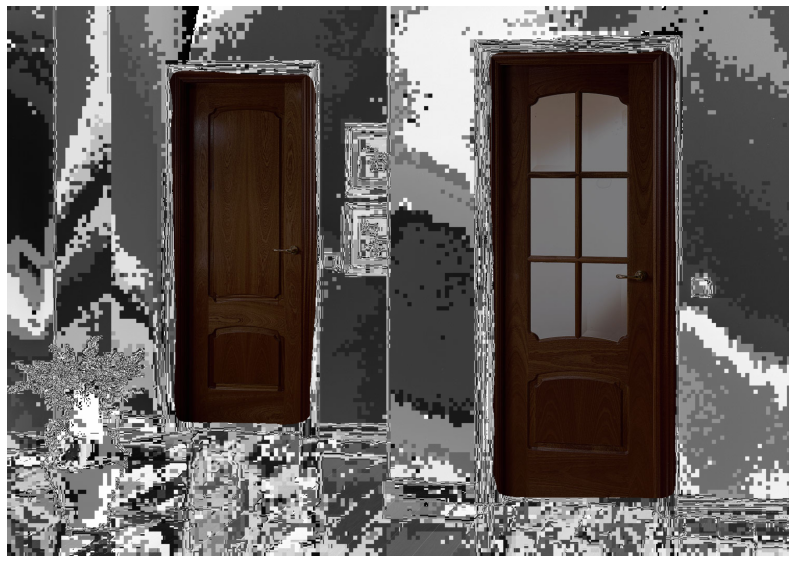

In [ ]:
from mrcnn.visualize import display_images
splash = color_splash(img, r['masks'])
display_images([splash], cols=1)

In [ ]:
detect_and_color_splash(model)

AssertionError: 